<a href="https://colab.research.google.com/github/tajerian/tensorflow/blob/colab/skin_cancer_Ham10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the essential libraries

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
print(f'TensorFlow version: {tf.__version__}')
print(f'\nAccessible devices: \n{(tf.config.list_physical_devices())}')

TensorFlow version: 2.9.2

Accessible devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Check GPU & its compute capability

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ef8bdd10-2903-a4ca-2158-9314f1eb837b)


In [5]:
print(f'is GPU built with cuda: {tf.test.is_built_with_cuda()}')
print(f'is compute capability at least 7.0: {tf.test.is_gpu_available(True, (7,0))}')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


is GPU built with cuda: True
is compute capability at least 7.0: True


In [6]:
# Get helper functions file
import os 

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2022-11-20 21:23:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-20 21:23:00 (84.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

#Downloading ham10000 dataset using kaggle API

In [8]:
# First go to your Kaggle account and create New API Token, a kaggle.json file will be download.

# Make sure you have a kaggle.json file.
!ls -lha /content/drive/MyDrive/kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# You must change "kmader/skin-cancer-mnist-ham10000" with the dataset you want.
# You can use copy API command from kaggle to be sure
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# Unzip data in Google Colab
!unzip -q /content/skin-cancer-mnist-ham10000.zip -d dataset

# Unzip data in Google Drive
#!unzip -q /content/skin-cancer-mnist-ham10000.zip -d '/content/gdrive/My Drive/ML data'

-rw------- 1 root root 68 Nov 19 19:25 /content/drive/MyDrive/kaggle.json
kaggle.json
100% 5.19G/5.20G [00:40<00:00, 149MB/s]
100% 5.20G/5.20G [00:40<00:00, 139MB/s]


#What is in the Kaggle skin-cancer-mnist-ham10000 data?
the *skin-cancer-mnist-ham10000.zip* file downled from kaggle contains HAM10000_images_part_1 with 5000 unlabled (450, 600, 3)images, HAM10000_images_part_2 with 5015 unlabled (450, 600, 3)images and a HAM10000_metadata csv file witch contains diagnosis for each image file in these two floders.
<br>***here you can see HAM10000_metadata.csv:***</br>







In [9]:
x=pd.read_csv("/content/dataset/HAM10000_metadata.csv")
x.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [10]:
n=np.asarray(x)
n=n[:,1:3]
n[:,0]=n[:,0]+'.jpg'
print(n.shape)
print(n[0])

(10015, 2)
['ISIC_0027419.jpg' 'bkl']


#labeling the images
TensorFlow APIs like tf.keras.preprocessing.image_dataset_from_directory or tensorflow.keras.preprocessing.image.ImageDataGenerator are commonly used to Generate batches of tensor image data with real-time data augmentation and these batches contain both image tenseros and one hot encoded lables together in a tuple.

> 🔑note: when you are going to fit the model by Train_Data Generated with ImageDataGenerator API as both image tenseros and lables are together in a tuple and Train_Data=(X_train, y_train), therefore model.fit(Train_Data,...) is used instead of model.fit(X=train_images,y=train_labels,...)

<br>ImageDataGenerator and image_dataset_from_directory APIs needs images of different classes to be in different folders and they label them based on alphabetic order of the each class folder.</br>
<br>***here we are going to move each image to its class folder:***</br>



In [11]:
all_images_dir='/content/ham10000'
os.mkdir(all_images_dir)

In [12]:
train_images_dir='/content/ham10000/train'
os.mkdir(train_images_dir)

In [13]:
train_images_dir='/content/ham10000/train/vasc'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/bkl'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/df'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/bcc'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/akiec'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/mel'
os.mkdir(train_images_dir)
train_images_dir='/content/ham10000/train/nv'
os.mkdir(train_images_dir)

In [14]:
test_images_dir='/content/ham10000/test'
os.mkdir(test_images_dir)

In [15]:
test_images_dir='/content/ham10000/test/vasc'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/bkl'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/df'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/bcc'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/akiec'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/mel'
os.mkdir(test_images_dir)
test_images_dir='/content/ham10000/test/nv'
os.mkdir(test_images_dir)

In [16]:
import shutil
i=0

for file_name in os.listdir('/content/dataset/HAM10000_images_part_1'):
    if file_name[0] in ['I']:
    
        if file_name in  n[:,0]:
        
            print(file_name)
            i=i+1
            result = np.where(n[:,0] == file_name)
            
            print(file_name)
            result=result[0][0]
            
            pos=int(result)
            pos=n[pos,1]
            print(pos)
            
            current0='/content/dataset/HAM10000_images_part_1/'+file_name
            direc0='/content/ham10000/train/'+pos+'/'+file_name
                #print (im)
            shutil.move(current0,direc0 )
print(i)      

Streaming output truncated to the last 5000 lines.
bkl
ISIC_0028372.jpg
ISIC_0028372.jpg
akiec
ISIC_0025217.jpg
ISIC_0025217.jpg
nv
ISIC_0028347.jpg
ISIC_0028347.jpg
bkl
ISIC_0027188.jpg
ISIC_0027188.jpg
df
ISIC_0026848.jpg
ISIC_0026848.jpg
akiec
ISIC_0027229.jpg
ISIC_0027229.jpg
bcc
ISIC_0026581.jpg
ISIC_0026581.jpg
nv
ISIC_0024432.jpg
ISIC_0024432.jpg
bcc
ISIC_0025531.jpg
ISIC_0025531.jpg
mel
ISIC_0026591.jpg
ISIC_0026591.jpg
nv
ISIC_0028362.jpg
ISIC_0028362.jpg
nv
ISIC_0025026.jpg
ISIC_0025026.jpg
nv
ISIC_0027783.jpg
ISIC_0027783.jpg
nv
ISIC_0027445.jpg
ISIC_0027445.jpg
nv
ISIC_0028575.jpg
ISIC_0028575.jpg
nv
ISIC_0024805.jpg
ISIC_0024805.jpg
mel
ISIC_0029278.jpg
ISIC_0029278.jpg
bcc
ISIC_0029052.jpg
ISIC_0029052.jpg
df
ISIC_0025437.jpg
ISIC_0025437.jpg
nv
ISIC_0028626.jpg
ISIC_0028626.jpg
nv
ISIC_0026068.jpg
ISIC_0026068.jpg
vasc
ISIC_0028778.jpg
ISIC_0028778.jpg
nv
ISIC_0026636.jpg
ISIC_0026636.jpg
nv
ISIC_0026881.jpg
ISIC_0026881.jpg
nv
ISIC_0025845.jpg
ISIC_0025845.jpg
nv
ISIC_0

In [17]:
import shutil
i=0

for file_name in os.listdir('/content/dataset/HAM10000_images_part_2'):
    if file_name[0] in ['I']:
    
        if file_name in  n[:,0]:
        
            print(file_name)
            i=i+1
            result = np.where(n[:,0] == file_name)
            
            print(file_name)
            result=result[0][0]
            
            pos=int(result)
            pos=n[pos,1]
            print(pos)
            
            current0='/content/dataset/HAM10000_images_part_2/'+file_name
            direc0='/content/ham10000/train/'+pos+'/'+file_name
                #print (im)
            shutil.move(current0,direc0 )
print(i)      

Streaming output truncated to the last 5000 lines.
nv
ISIC_0031703.jpg
ISIC_0031703.jpg
nv
ISIC_0031331.jpg
ISIC_0031331.jpg
nv
ISIC_0029849.jpg
ISIC_0029849.jpg
bkl
ISIC_0032357.jpg
ISIC_0032357.jpg
nv
ISIC_0029883.jpg
ISIC_0029883.jpg
nv
ISIC_0033742.jpg
ISIC_0033742.jpg
nv
ISIC_0031456.jpg
ISIC_0031456.jpg
nv
ISIC_0029471.jpg
ISIC_0029471.jpg
nv
ISIC_0029777.jpg
ISIC_0029777.jpg
nv
ISIC_0031916.jpg
ISIC_0031916.jpg
nv
ISIC_0031498.jpg
ISIC_0031498.jpg
mel
ISIC_0030575.jpg
ISIC_0030575.jpg
mel
ISIC_0030003.jpg
ISIC_0030003.jpg
nv
ISIC_0030141.jpg
ISIC_0030141.jpg
nv
ISIC_0033947.jpg
ISIC_0033947.jpg
mel
ISIC_0032929.jpg
ISIC_0032929.jpg
bkl
ISIC_0033930.jpg
ISIC_0033930.jpg
nv
ISIC_0030227.jpg
ISIC_0030227.jpg
bkl
ISIC_0033114.jpg
ISIC_0033114.jpg
mel
ISIC_0034245.jpg
ISIC_0034245.jpg
nv
ISIC_0032321.jpg
ISIC_0032321.jpg
nv
ISIC_0030823.jpg
ISIC_0030823.jpg
nv
ISIC_0029985.jpg
ISIC_0029985.jpg
nv
ISIC_0030534.jpg
ISIC_0030534.jpg
nv
ISIC_0032819.jpg
ISIC_0032819.jpg
nv
ISIC_0031834.j

so as you see in the block below, from total 1015 images:

0.   327 images belonges to class akiec
1.   514 images belonges to class bcc
2.   1099 images belonges to class bkl
3.   115 images belonges to class df
4.   1113 images belonges to class mel
5.   6705 images belonges to class nv
6.   142 images belonges to class vasc

<br>***Now we need to split these images to Train and Test sets:***</br>




In [18]:
class_names=sorted(os.listdir('/content/ham10000/train'))
for classes in class_names:
  print(f'number of images in class {classes} =',len(os.listdir('/content/ham10000/train/'+classes)))

number of images in class akiec = 327
number of images in class bcc = 514
number of images in class bkl = 1099
number of images in class df = 115
number of images in class mel = 1113
number of images in class nv = 6705
number of images in class vasc = 142


In [19]:
i=0

for file_name in os.listdir('/content/ham10000/train'):
    
    
    
      if file_name in  n[:,1]:
        i=0
        m=[]
        direc=os.listdir('/content/ham10000/train/'+file_name)
        for j in range(int(.2*len(os.listdir('/content/ham10000/train/'+file_name)))):
          a=random.choice(direc)
          direc.remove(a)
          m.append(a)
          i+=1
        for im in m:
          current0='/content/ham10000/train/'+file_name+'/'+im
          direc0=  '/content/ham10000/test/'+file_name+'/'+im
          shutil.move(current0,direc0)
          print(im,'is moved to test in class=',file_name)
        print(i)

ISIC_0027135.jpg is moved to test in class= bcc
ISIC_0032318.jpg is moved to test in class= bcc
ISIC_0025630.jpg is moved to test in class= bcc
ISIC_0025301.jpg is moved to test in class= bcc
ISIC_0027281.jpg is moved to test in class= bcc
ISIC_0024897.jpg is moved to test in class= bcc
ISIC_0032959.jpg is moved to test in class= bcc
ISIC_0032741.jpg is moved to test in class= bcc
ISIC_0031378.jpg is moved to test in class= bcc
ISIC_0028035.jpg is moved to test in class= bcc
ISIC_0031263.jpg is moved to test in class= bcc
ISIC_0028978.jpg is moved to test in class= bcc
ISIC_0029489.jpg is moved to test in class= bcc
ISIC_0030915.jpg is moved to test in class= bcc
ISIC_0027846.jpg is moved to test in class= bcc
ISIC_0029053.jpg is moved to test in class= bcc
ISIC_0032022.jpg is moved to test in class= bcc
ISIC_0027093.jpg is moved to test in class= bcc
ISIC_0025818.jpg is moved to test in class= bcc
ISIC_0028283.jpg is moved to test in class= bcc
ISIC_0026321.jpg is moved to test in cla

#number of images in each class for test and train datasets

In [20]:
for classes in class_names:
  print(f'number of images in class {classes} of train set =',len(os.listdir('/content/ham10000/train/'+classes)))

number of images in class akiec of train set = 262
number of images in class bcc of train set = 412
number of images in class bkl of train set = 880
number of images in class df of train set = 92
number of images in class mel of train set = 891
number of images in class nv of train set = 5364
number of images in class vasc of train set = 114


In [21]:
for classes in class_names:
  print(f'number of images in class {classes} of test set =',len(os.listdir('/content/ham10000/test/'+classes)))

number of images in class akiec of test set = 65
number of images in class bcc of test set = 102
number of images in class bkl of test set = 219
number of images in class df of test set = 23
number of images in class mel of test set = 222
number of images in class nv of test set = 1341
number of images in class vasc of test set = 28


In [22]:
# Import the required modules for model creation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import layers
import datetime

#making functions to systematicly create,compile,fit,save and ploting models:

In [42]:
def prepare_for_train_test(train_dir= '/content/ham10000/train',
                           test_dir= '/content/ham10000/test',
                           IMG_SIZE = (300, 400),
                           data_aug=False):
    if data_aug==False:
      print('no data augmentaion on train data....')
      train_datagen = ImageDataGenerator()
    if data_aug:
      print('using data augmentaion on train data....')
      train_datagen = ImageDataGenerator( rotation_range = 10,
                                          width_shift_range = 0.2,
                                          height_shift_range = 0.2,
                                          shear_range = 0.2,
                                          horizontal_flip = True,
                                          vertical_flip = True,
                                          fill_mode = 'nearest')
    train_data = train_datagen.flow_from_directory(directory=train_dir,
                                                   class_mode="categorical",
                                                   target_size=IMG_SIZE)
                                                                                    
    test_datagen = ImageDataGenerator()
    test_data = test_datagen.flow_from_directory(directory=test_dir,
                                              class_mode="categorical",
                                              target_size=IMG_SIZE,
                                              shuffle=False) # don't shuffle test data for prediction analysis
    
    return train_data, test_data

In [24]:
transfer_model= 'EfficientNetB5'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
def create_model(img_shape=(300,400), num_class=7):

    # Setup model architecture with trainable top layers
    inputs = layers.Input(shape=img_shape+(3,), name="input_layer") # shape of input image
    x = inputs   
    x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
    x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
    outputs = layers.Dense(num_class, activation="softmax", name="output_layer")(x) # same number of outputs as classes
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])
    print(model.summary())
    return model;

115263384/115263384 [==============================] - 1s 0us/step


In [25]:
def train_model(model, train_data, EPOCHS=5, experiment_name="efficientnetB0", directory='/content/drive/MyDrive/models/ham1000', fine_tune=False):
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, 
                           mode='auto')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, 
                              verbose=1, mode='auto')
    # Create checkpoint callback to save model for later use
    checkpoint_path = "best_model"+experiment_name+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                            save_weights_only=True, # save only the model weights
                                                            monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                            save_best_only=True) # only keep the best model weights on file (delete the rest)
        
    if fine_tune==False:
      history = model.fit(train_data,
                          validation_data=test_data,
                          validation_steps= len(test_data),
                          epochs = EPOCHS,
                          callbacks = [reduce_lr,
                                      early_stop,
                                      create_tensorboard_callback(dir_name="/content/drive/MyDrive/tensor board log/ham10000_effi",experiment_name=experiment_name),
                                      checkpoint_callback])
    if fine_tune:
      history = model.fit(train_data,
                          validation_data=test_data,
                          validation_steps= len(test_data),
                          epochs = EPOCHS*2,
                          initial_epoch= EPOCHS-1,
                          callbacks = [reduce_lr,
                                      early_stop,
                                      create_tensorboard_callback(dir_name="/content/drive/MyDrive/tensor board log/ham10000_effi",experiment_name=experiment_name),
                                      checkpoint_callback])
    os.mkdir(directory+'/'+experiment_name)
    model.save(directory+'/'+experiment_name+'/'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return history


In [26]:
def unfreeze(model, num_layers=10):
  """
  unfreeze top layers of the functional models to prepare them for fine tuning
  
  Parameters
  ----------
  model: tf.model obj
  num_layers(int): number of top layers of the base model to set them trainable.
  """
  # Unfreeze all of the layers in the base model
  base_model.trainable = True

  # Refreeze every layer except for the last 10
  for layer in base_model.layers[:-(num_layers)]:
    layer.trainable = False
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001), # use Adam with default settings
                metrics=["accuracy"])
  print(model.summary())

#prepare for train_test data

In [43]:
train_data, test_data = prepare_for_train_test(train_dir= '/content/ham10000/train',
                           test_dir= '/content/ham10000/test',
                           IMG_SIZE = (300, 400),
                           data_aug=False)
train_data_aug, test_data_aug = prepare_for_train_test(train_dir= '/content/ham10000/train',
                           test_dir= '/content/ham10000/test',
                           IMG_SIZE = (300, 400),
                           data_aug=True)

no data augmentaion on train data....
Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
using data augmentaion on train data....
Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.


#EfficientNetB0

##Feature extraction with out data augmentaion


In [35]:
transfer_model= 'EfficientNetB0'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b0= create_model(img_shape=(450,600), num_class=7)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0/20221120-215609
Epoch 1/5
251/251 [==============================] - 157s 597ms/step - loss: 0.9031 - accuracy: 0.6881 - val_loss: 0.7742 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 154s 611ms/step - loss: 0.7355 - accuracy: 0.7342 - val_loss: 0.6977 - val_accuracy: 0.7560 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 143s 570ms/step - loss: 0.6780 - accuracy: 0.7580 - val_loss: 0.6611 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 140s 557ms/step - loss: 0.6387 - accuracy: 0.7708 - val_loss: 0.6276 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 141s 560ms/step - loss: 0.6117 - accuracy: 0.7780 - val_loss: 0.6162 - val_accuracy: 0.7865 - lr: 0.0010


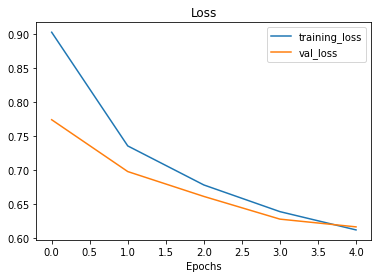

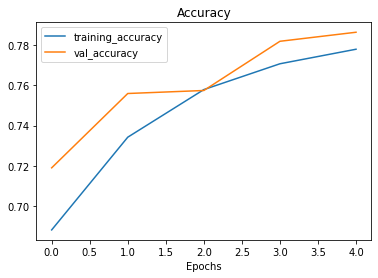

In [36]:
history_b0= train_model(model_b0, train_data, experiment_name="efficientnetB0", EPOCHS=5)
plot_loss_curves(history_b0)

##FineTuning with out data augmentaion 

In [37]:
unfreeze(model_b0, num_layers=10)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 902,199
Non-trainable params: 3,156,339
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0_finetune/20221120-221142
Epoch 5/10
251/251 [==============================] - 157s 596ms/step - loss: 0.5692 - accuracy: 0.7885 - val_loss: 0.5630 - val_accuracy: 0.8035 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 145s 576ms/step - loss: 0.5008 - accuracy: 0.8150 - val_loss: 0.5547 - val_accuracy: 0.7955 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 145s 579ms/step - loss: 0.4549 - accuracy: 0.8361 - val_loss: 0.4954 - val_accuracy: 0.8340 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 145s 576ms/step - loss: 0.4218 - accuracy: 0.8463 - val_loss: 0.4967 - val_accuracy: 0.8270 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 158s 629ms/step - loss: 0.3927 - accuracy: 0.8608 - val_loss: 0.4626 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 10/10
251/251 [==============================] - 145

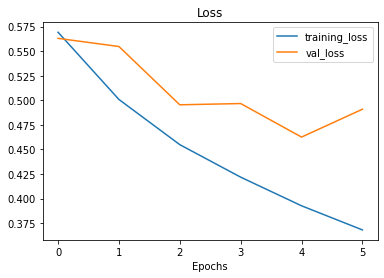

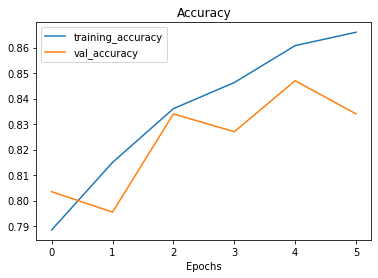

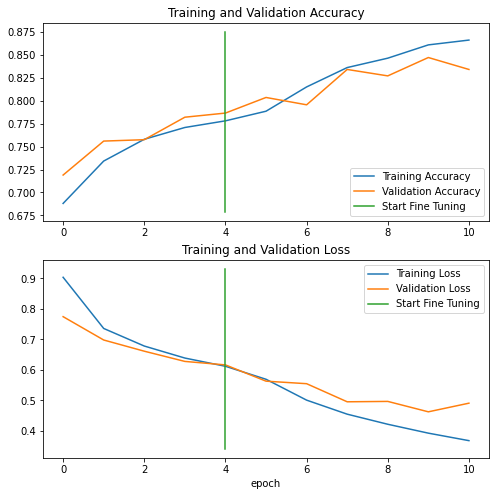

In [38]:
history_b0_finetune= train_model(model_b0, train_data, experiment_name="efficientnetB0_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b0_finetune)
compare_historys(history_b0,
                 history_b0_finetune,
                 initial_epochs=5)

##Feature extraction with data augmentaion

In [40]:
transfer_model= 'EfficientNetB0'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b0_aug= create_model(img_shape=(450,600), num_class=7)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 8,967
Non-trainable params: 4,049,571
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0_aug/20221120-223252
Epoch 1/5
251/251 [==============================] - 540s 2s/step - loss: 0.9188 - accuracy: 0.6781 - val_loss: 0.8135 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 523s 2s/step - loss: 0.7577 - accuracy: 0.7239 - val_loss: 0.7216 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 531s 2s/step - loss: 0.7049 - accuracy: 0.7419 - val_loss: 0.6853 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 545s 2s/step - loss: 0.6678 - accuracy: 0.7626 - val_loss: 0.6503 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 518s 2s/step - loss: 0.6430 - accuracy: 0.7637 - val_loss: 0.6530 - val_accuracy: 0.7755 - lr: 0.0010


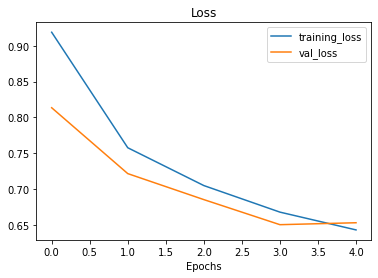

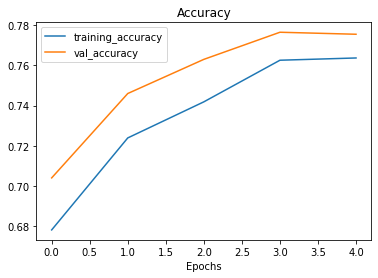

In [44]:
history_b0_aug= train_model(model_b0_aug, train_data_aug, experiment_name="efficientnetB0_aug", EPOCHS=5)
plot_loss_curves(history_b0_aug)

##FineTuning with data augmentaion 

In [50]:
unfreeze(model_b0_aug, num_layers=5)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 450, 600, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 4,058,538
Trainable params: 790,407
Non-trainable params: 3,268,131
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB0_aug_finetune/20221120-234013
Epoch 5/10
251/251 [==============================] - 538s 2s/step - loss: 0.6155 - accuracy: 0.7698 - val_loss: 0.6377 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 528s 2s/step - loss: 0.5514 - accuracy: 0.7960 - val_loss: 0.5972 - val_accuracy: 0.8005 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 528s 2s/step - loss: 0.5155 - accuracy: 0.8090 - val_loss: 0.6545 - val_accuracy: 0.7600 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - ETA: 0s - loss: 0.4931 - accuracy: 0.8190
Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
251/251 [==============================] - 540s 2s/step - loss: 0.4931 - accuracy: 0.8190 - val_loss: 0.6808 - val_accuracy: 0.7615 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - 527s 2s/step -

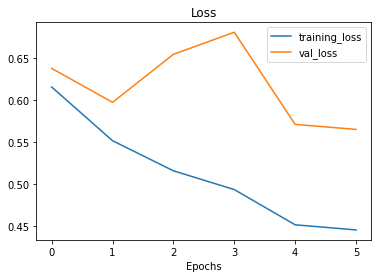

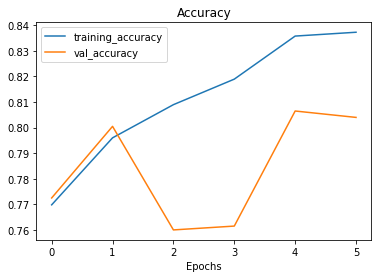

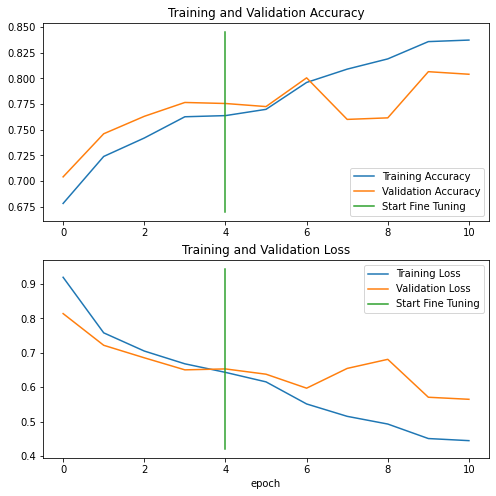

In [51]:
history_b0_aug_finetune= train_model(model_b0_aug, train_data_aug, experiment_name="efficientnetB0_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b0_aug_finetune)
compare_historys(history_b0_aug,
                 history_b0_aug_finetune,
                 initial_epochs=5)

#EfficientNetB1

In [52]:
transfer_model= 'EfficientNetB1'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b1= create_model(img_shape=(300,400), num_class=7)

27018416/27018416 [==============================] - 0s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 8,967
Non-trainable params: 6,575,239
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB1/20221121-004927
Epoch 1/5
251/251 [==============================] - 167s 632ms/step - loss: 0.8679 - accuracy: 0.6918 - val_loss: 0.7380 - val_accuracy: 0.7365 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 160s 638ms/step - loss: 0.7134 - accuracy: 0.7365 - val_loss: 0.6655 - val_accuracy: 0.7575 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 151s 600ms/step - loss: 0.6518 - accuracy: 0.7572 - val_loss: 0.6315 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 157s 623ms/step - loss: 0.6136 - accuracy: 0.7727 - val_loss: 0.6111 - val_accuracy: 0.7780 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 167s 665ms/step - loss: 0.5818 - accuracy: 0.7828 - val_loss: 0.5961 - val_accuracy: 0.7810 - lr: 0.0010


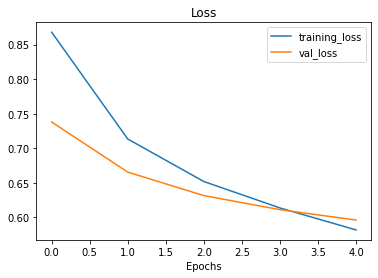

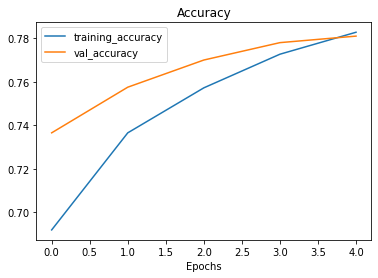

In [53]:
history_b1= train_model(model_b1, train_data, experiment_name="efficientnetB1", EPOCHS=5)
plot_loss_curves(history_b1)

In [56]:
unfreeze(model_b1, num_layers=10)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 1,345,367
Non-trainable params: 5,238,839
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB1_finetune/20221121-012521
Epoch 5/10
251/251 [==============================] - 170s 643ms/step - loss: 0.5403 - accuracy: 0.7938 - val_loss: 0.5480 - val_accuracy: 0.8095 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 167s 665ms/step - loss: 0.4751 - accuracy: 0.8243 - val_loss: 0.5159 - val_accuracy: 0.8190 - lr: 1.0000e-04
Epoch 7/10
251/251 [==============================] - 169s 671ms/step - loss: 0.4160 - accuracy: 0.8518 - val_loss: 0.4913 - val_accuracy: 0.8285 - lr: 1.0000e-04
Epoch 8/10
251/251 [==============================] - 165s 656ms/step - loss: 0.3778 - accuracy: 0.8634 - val_loss: 0.5007 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 9/10
251/251 [==============================] - ETA: 0s - loss: 0.3396 - accuracy: 0.8779
Epoch 9: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
251/251 [==============================] - 162s 6

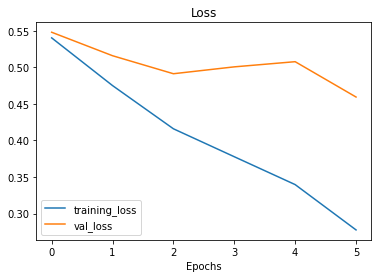

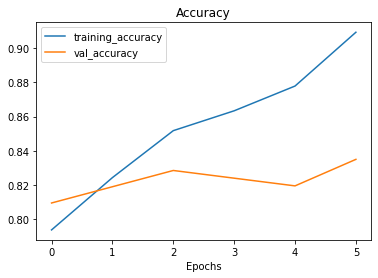

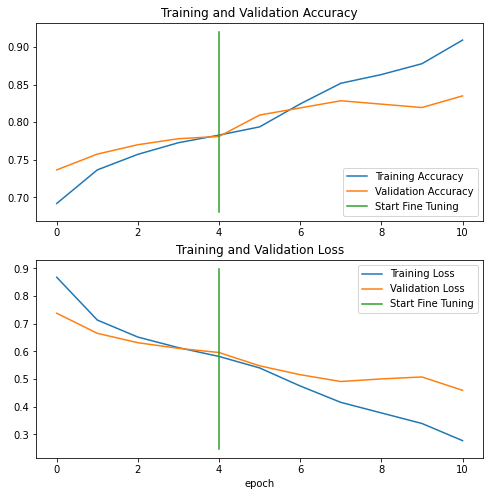

In [57]:
history_b1_finetune= train_model(model_b1, train_data, experiment_name="efficientnetB1_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b1_finetune)
compare_historys(history_b1,
                 history_b1_finetune,
                 initial_epochs=5)

In [58]:
transfer_model= 'EfficientNetB1'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b1_aug= create_model(img_shape=(300,400), num_class=7)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 8,967
Non-trainable params: 6,575,239
_________________________________________________________________
None


Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB1_aug/20221121-015228
Epoch 1/5
251/251 [==============================] - 559s 2s/step - loss: 0.8914 - accuracy: 0.6828 - val_loss: 0.7814 - val_accuracy: 0.7135 - lr: 0.0010
Epoch 2/5
251/251 [==============================] - 546s 2s/step - loss: 0.7287 - accuracy: 0.7341 - val_loss: 0.7130 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 3/5
251/251 [==============================] - 526s 2s/step - loss: 0.6691 - accuracy: 0.7527 - val_loss: 0.6786 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 4/5
251/251 [==============================] - 522s 2s/step - loss: 0.6327 - accuracy: 0.7664 - val_loss: 0.6456 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 5/5
251/251 [==============================] - 516s 2s/step - loss: 0.6067 - accuracy: 0.7754 - val_loss: 0.6310 - val_accuracy: 0.7675 - lr: 0.0010


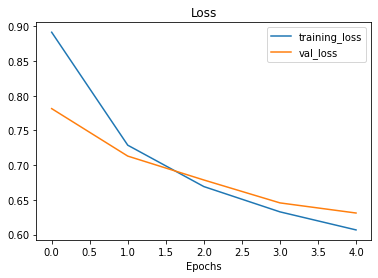

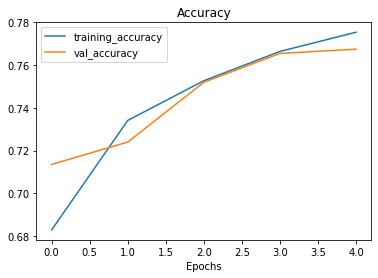

In [59]:
history_b1_aug= train_model(model_b1_aug, train_data_aug, experiment_name="efficientnetB1_aug", EPOCHS=5)
plot_loss_curves(history_b1_aug)

In [60]:
unfreeze(model_b1_aug, num_layers=10)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 300, 400, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, None, None, 1280)  6575239  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 7)                 8967      
                                                                 
Total params: 6,584,206
Trainable params: 1,345,367
Non-trainable params: 5,238,839
_________________________________________________________________
None


In [ ]:
history_b1_aug_finetune= train_model(model_b1_aug, train_data_aug, experiment_name="efficientnetB1_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b1_aug_finetune)
compare_historys(history_b1_aug,
                 history_b1_aug_finetune,
                 initial_epochs=5)

Saving TensorBoard log files to: /content/drive/MyDrive/tensor board log/ham10000_effi/efficientnetB1_aug_finetune/20221121-024808
Epoch 5/10
251/251 [==============================] - 539s 2s/step - loss: 0.5744 - accuracy: 0.7855 - val_loss: 0.6356 - val_accuracy: 0.7705 - lr: 1.0000e-04
Epoch 6/10
251/251 [==============================] - 526s 2s/step - loss: 0.5143 - accuracy: 0.8102 - val_loss: 0.7032 - val_accuracy: 0.7580 - lr: 1.0000e-04
Epoch 7/10
137/251 [===============>..............] - ETA: 3:45 - loss: 0.4866 - accuracy: 0.8216

#EfficientNetB2

In [ ]:
transfer_model= 'EfficientNetB2'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b2= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b2= train_model(model_b2, train_data, experiment_name="efficientnetB2", EPOCHS=5)
plot_loss_curves(history_b2)

In [ ]:
unfreeze(model_b2, num_layers=10)

In [ ]:
history_b2_finetune= train_model(model_b2, train_data, experiment_name="efficientnetB2_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b2_finetune)
compare_historys(history_b2,
                 history_b2_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB2'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b2_aug= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b2_aug= train_model(model_b2_aug, train_data_aug, experiment_name="efficientnetB2_aug", EPOCHS=5)
plot_loss_curves(history_b2_aug)

In [ ]:
unfreeze(model_b2_aug, num_layers=10)

In [ ]:
history_b2_aug_finetune= train_model(model_b2_aug, train_data_aug, experiment_name="efficientnetB2_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b2_aug_finetune)
compare_historys(history_b2_aug,
                 history_b2_aug_finetune,
                 initial_epochs=5)

#EfficientNetB3

In [ ]:
transfer_model= 'EfficientNetB3'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b3= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b3= train_model(model_b3, train_data, experiment_name="efficientnetB3", EPOCHS=5)
plot_loss_curves(history_b3)

In [ ]:
unfreeze(model_b3, num_layers=10)

In [ ]:
history_b3_finetune= train_model(model_b3, train_data, experiment_name="efficientnetB3_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b3_finetune)
compare_historys(history_b3,
                 history_b3_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB3'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b3_aug= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b3_aug= train_model(model_b3_aug, train_data_aug, experiment_name="efficientnetB3_aug", EPOCHS=5)
plot_loss_curves(history_b3_aug)

In [ ]:
unfreeze(model_b3_aug, num_layers=10)

In [ ]:
history_b3_aug_finetune= train_model(model_b3_aug, train_data_aug, experiment_name="efficientnetB3_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b3_aug_finetune)
compare_historys(history_b3_aug,
                 history_b3_aug_finetune,
                 initial_epochs=5)

#EfficientNetB4

In [ ]:
transfer_model= 'EfficientNetB4'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b4= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b4= train_model(model_b4, train_data, experiment_name="efficientnetB4", EPOCHS=5)
plot_loss_curves(history_b4)

In [ ]:
unfreeze(model_b4, num_layers=10)

In [ ]:
history_b4_finetune= train_model(model_b4, train_data, experiment_name="efficientnetB4_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b4_finetune)
compare_historys(history_b4,
                 history_b4_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB4'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b4_aug= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b4_aug= train_model(model_b4_aug, train_data_aug, experiment_name="efficientnetB4_aug", EPOCHS=5)
plot_loss_curves(history_b4_aug)

In [ ]:
unfreeze(model_b4_aug, num_layers=10)

In [ ]:
history_b4_aug_finetune= train_model(model_b4_aug, train_data_aug, experiment_name="efficientnetB4_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b4_aug_finetune)
compare_historys(history_b4_aug,
                 history_b4_aug_finetune,
                 initial_epochs=5)

#EfficientNetB5

In [ ]:
transfer_model= 'EfficientNetB5'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b5= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b5= train_model(model_b5, train_data, experiment_name="efficientnetB5", EPOCHS=5)
plot_loss_curves(history_b5)

In [ ]:
unfreeze(model_b5, num_layers=10)

In [ ]:
history_b5_finetune= train_model(model_b5, train_data, experiment_name="efficientnetB5_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b5_finetune)
compare_historys(history_b5,
                 history_b5_finetune,
                 initial_epochs=5)

In [ ]:
transfer_model= 'EfficientNetB5'
exec('base_model = tf.keras.applications.'+transfer_model+'(include_top=False)')
base_model.trainable = False
model_b5_aug= create_model(img_shape=(450,600), num_class=7)

In [ ]:
history_b5_aug= train_model(model_b5_aug, train_data_aug, experiment_name="efficientnetB5_aug", EPOCHS=5)
plot_loss_curves(history_b5_aug)

In [ ]:
unfreeze(model_b5_aug, num_layers=10)

In [ ]:
history_b5_aug_finetune= train_model(model_b5_aug, train_data_aug, experiment_name="efficientnetB5_aug_finetune", EPOCHS=5, fine_tune=True)
plot_loss_curves(history_b5_aug_finetune)
compare_historys(history_b5_aug,
                 history_b5_aug_finetune,
                 initial_epochs=5)

#uploading the training logs to TensorBoard:

In [ ]:
!tensorboard dev upload --logdir '/content/drive/MyDrive/tensor board log/ham10000_effi' \
  --name "ham10000_efficientnet" \
  --description "transfer learning using efficientnet models to classify skin cancer images" \
  --one_shot

# Making the best model: